In [26]:
from dotenv import load_dotenv
import os
load_dotenv()
api_key=os.getenv('NEWS_API_KEY')
llm_api_key=os.getenv("LLM_API_KEY")

In [38]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [28]:
import requests
import pandas as pd
from newsapi import NewsApiClient
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
from langchain.chat_models import ChatOpenAI
import logging
from typing import List, Dict, Optional
import json
import warnings
warnings.filterwarnings('ignore')

In [30]:
class NewsAnalyzer:
    def __init__(self, news_api_key: str, openai_api_key: str):
        """Initialize the NewsAnalyzer with API keys."""
        self.news_api_key = news_api_key
        self.openai_api_key = openai_api_key
        self.newsapi = NewsApiClient(api_key=self.news_api_key)
        self.llm = ChatOpenAI(
            model_name="gpt-3.5-turbo",
            temperature=0.1,
            openai_api_key=self.openai_api_key
        )
    
    def fetch_news(self, query: str, from_date: datetime, to_date: datetime, 
                   language: str = 'en', sort_by: str = 'relevancy', 
                   page_size: int = 100) -> pd.DataFrame:
        """Fetch news articles with improved error handling."""
        try:
            query = query.replace(' ', ' AND ')
            
            #articles with pagination
            all_articles = []
            page = 1
            
            while len(all_articles) < page_size:
                try:
                    articles = self.newsapi.get_everything(
                        q=query,
                        from_param=from_date.strftime('%Y-%m-%d'),
                        to=to_date.strftime('%Y-%m-%d'),
                        language=language,
                        sort_by=sort_by,
                        page_size=min(100, page_size - len(all_articles)),
                        page=page
                    )
                    
                    if 'articles' in articles and articles['articles']:
                        all_articles.extend(articles['articles'])
                        page += 1
                    else:
                        break
                        
                except Exception as e:
                    logger.error(f"Error fetching articles page {page}: {e}")
                    break
            
            if all_articles:
                df = pd.DataFrame(all_articles)
                logger.info(f"Successfully fetched {len(df)} articles")
                return df
            else:
                logger.warning("No articles found")
                return pd.DataFrame()
                
        except Exception as e:
            logger.error(f"Error in fetch_news: {e}")
            return pd.DataFrame()
    
    def preprocess_news_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Preprocess news data with improved data cleaning."""
        if df.empty:
            return df
        
        try:
            # copy of original data
            df_copy = df.copy()
            
            if 'source' in df_copy.columns:
                df_copy = df_copy.drop('source', axis=1)
            
            # Convert publishedAt to datetime
            df_copy['publishedAt'] = pd.to_datetime(df_copy['publishedAt'])
            
            # Clean title and description
            df_copy['title'] = df_copy['title'].fillna('')
            df_copy['description'] = df_copy['description'].fillna('')
            
            # Remove articles without author or title
            df_copy = df_copy[df_copy['author'].notna()]
            df_copy = df_copy[df_copy['title'] != '']
            
            # Extract date features
            df_copy['date'] = df_copy['publishedAt'].dt.date
            df_copy['hour'] = df_copy['publishedAt'].dt.hour
            
            return df_copy
            
        except Exception as e:
            logger.error(f"Error in preprocess_news_data: {e}")
            return pd.DataFrame()
    
    def extract_sentiment_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract sentiment features from news content."""
        if df.empty:
            return df
        
        try:
            # Simple sentiment indicators
            positive_words = [
                                'growth', 'profit', 'gain', 'positive', 'strong', 'increase', 'beat', 'exceed', 'improve', 'record',
                                'surge', 'expand', 'boost', 'rise', 'outperform', 'upgrade', 'innovation', 'success', 'rebound',
                                'recover', 'uptrend', 'bullish', 'resilient', 'stable', 'confidence', 'optimistic', 'stronger',
                                'advancement', 'leadership', 'strategic', 'solid', 'impressive', 'momentum', 'accelerate'
                            ]

            negative_words = [
                                'loss', 'decline', 'drop', 'negative', 'weak', 'decrease', 'miss', 'fall', 'concern', 'challenge',
                                'slump', 'downgrade', 'warning', 'slowdown', 'uncertain', 'volatile', 'instability', 'cut', 'lawsuit',
                                'fallout', 'missed', 'delay', 'recession', 'layoff', 'lawsuit', 'risk', 'shortfall', 'collapse',
                                'fraud', 'breach', 'disappoint', 'downturn', 'struggle', 'bankruptcy'
                            ]

            
            def get_sentiment_score(text: str) -> int:
                text_lower = text.lower()
                positive_count = sum(1 for word in positive_words if word in text_lower)
                negative_count = sum(1 for word in negative_words if word in text_lower)
                return positive_count - negative_count
            
            df['sentiment_score'] = df.apply(lambda row: get_sentiment_score(row['title'] + ' ' + row.get('description', '')), axis=1)
            df['sentiment_category'] = df['sentiment_score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
            
            return df
            
        except Exception as e:
            logger.error(f"Error in extract_sentiment_features: {e}")
            return df
    
    def visualize_sentiment_trends(self, df: pd.DataFrame, company_name: str) -> None:
        """Create comprehensive visualizations for sentiment analysis."""
        if df.empty:
            logger.warning("No data to visualize")
            return
        
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 1])
        
        #Sentiment Distribution Pie Chart
        ax1 = fig.add_subplot(gs[0, 0])
        sentiment_counts = df['sentiment_category'].value_counts()
        colors = {'Positive': '#4CAF50', 'Negative': '#F44336', 'Neutral': '#9E9E9E'}
        pie_colors = [colors.get(cat, '#9E9E9E') for cat in sentiment_counts.index]
        
        ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
                colors=pie_colors, startangle=90)
        ax1.set_title(f'Sentiment Distribution - {company_name}', fontsize=14, fontweight='bold')
        
        #Sentiment Over Time
        ax2 = fig.add_subplot(gs[0, 1])
        daily_sentiment = df.groupby('date')['sentiment_score'].mean()
        positive_days = daily_sentiment[daily_sentiment > 0]
        negative_days = daily_sentiment[daily_sentiment < 0]
        neutral_days = daily_sentiment[daily_sentiment == 0]
        
        ax2.plot(daily_sentiment.index, daily_sentiment.values, marker='o', linestyle='-', color='blue', alpha=0.5)
        ax2.scatter(positive_days.index, positive_days.values, color='green', s=100, label='Positive', zorder=5)
        ax2.scatter(negative_days.index, negative_days.values, color='red', s=100, label='Negative', zorder=5)
        ax2.scatter(neutral_days.index, neutral_days.values, color='gray', s=100, label='Neutral', zorder=5)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.set_title(f'Daily Sentiment Trend - {company_name}', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Average Sentiment Score')
        ax2.legend()
        ax2.tick_params(axis='x', rotation=45)
        
        # Top Topics (Word Cloud alternative - top words from titles)
        ax3 = fig.add_subplot(gs[1, :])
        # Extracting top words from titles
        all_words = ' '.join(df['title']).lower()
        words = re.findall(r'\b\w+\b', all_words)
        word_freq = pd.Series(words).value_counts()
        common_words = ['the', 'and', 'for', 'are', 'but', 'not', 'you', 'all', 'any', 'can', 'had', 'her', 'was', 'one', 'our', 'out', 'day', 'get', 'has', 'him', 'his', 'how', 'man', 'new', 'now', 'old', 'see', 'two', 'way', 'who', 'boy', 'did', 'its', 'let', 'put', 'say', 'she', 'too', 'use']
        word_freq = word_freq[~word_freq.index.isin(common_words)]
        top_words = word_freq.head(15)
        
        sns.barplot(x=top_words.values, y=top_words.index, ax=ax3, palette='viridis')
        ax3.set_title(f'Top Keywords in News Headlines - {company_name}', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Frequency')
        
        #Articles by Hour
        ax4 = fig.add_subplot(gs[2, 0])
        hourly_counts = df['hour'].value_counts().sort_index()
        ax4.bar(hourly_counts.index, hourly_counts.values, color='skyblue', edgecolor='navy')
        ax4.set_title(f'Article Publication by Hour - {company_name}', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Hour of Day')
        ax4.set_ylabel('Number of Articles')
        ax4.set_xticks(range(0, 24, 2))
        
        #Top Authors
        ax5 = fig.add_subplot(gs[2, 1])
        top_authors = df['author'].value_counts().head(10)
        sns.barplot(x=top_authors.values, y=top_authors.index, ax=ax5, palette='coolwarm')
        ax5.set_title(f'Top {min(10, len(top_authors))} Authors - {company_name}', fontsize=14, fontweight='bold')
        ax5.set_xlabel('Number of Articles')
        
        plt.tight_layout()
        plt.savefig(f'{company_name.lower().replace(" ", "_")}_sentiment_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def build_enhanced_prompt(self, df: pd.DataFrame, company_name: str) -> str:
        """Build an enhanced prompt for LLM analysis."""
        prompt = f"You are a financial analyst tasked with providing insights into recent news articles about {company_name}.\n\n"
        
        #summary statistics
        if not df.empty:
            total_articles = len(df)
            sentiment_stats = df['sentiment_category'].value_counts()
            
            prompt += f"SUMMARY STATISTICS:\n"
            prompt += f"- Total articles analyzed: {total_articles}\n"
            prompt += f"- Positive articles: {sentiment_stats.get('Positive', 0)} ({sentiment_stats.get('Positive', 0)/total_articles*100:.1f}%)\n"
            prompt += f"- Negative articles: {sentiment_stats.get('Negative', 0)} ({sentiment_stats.get('Negative', 0)/total_articles*100:.1f}%)\n"
            prompt += f"- Neutral articles: {sentiment_stats.get('Neutral', 0)} ({sentiment_stats.get('Neutral', 0)/total_articles*100:.1f}%)\n\n"
            
            prompt += "RECENT NEWS HEADLINES:\n\n"
            
            # Adding recent articles by category
            for category in ['Positive', 'Negative', 'Neutral']:
                category_articles = df[df['sentiment_category'] == category].sort_values('publishedAt', ascending=False).head(5)
                if not category_articles.empty:
                    prompt += f"{category.upper()} NEWS:\n"
                    for _, row in category_articles.iterrows():
                        prompt += f"- {row['title']} ({row['publishedAt'].strftime('%Y-%m-%d')})\n"
                    prompt += "\n"
        
        prompt += """
ANALYSIS REQUEST:
Please provide:
1. Overall sentiment trend for {company_name}
2. Key factors driving positive/negative sentiment
3. Potential market impacts
4. Suggestions for investors or stakeholders
5. Notable emerging themes or patterns

Format your response with clear sections and bullet points where appropriate.
""".format(company_name=company_name)
        
        return prompt
    
    def generate_analysis_report(self, df: pd.DataFrame, company_name: str) -> str:
        """Generate a comprehensive analysis report."""
        try:
            prompt = self.build_enhanced_prompt(df, company_name)
            response = self.llm.invoke(prompt)
            return response.content
        except Exception as e:
            logger.error(f"Error generating analysis report: {e}")
            return "Error generating analysis report."

In [32]:
def analyze_company(analyzer, company_name, days_back=15):
    """Analyze news sentiment for a single company."""
    # Get date range
    current_time = datetime.now()
    from_date = current_time - timedelta(days=days_back)
    
    # Fetch and process news
    print(f"Fetching news for {company_name}...")
    query = f"{company_name} News"
    df = analyzer.fetch_news(query, from_date, current_time)
    
    results = {
        'company': company_name,
        'articles_count': 0,
        'has_data': False,
        'report_path': None,
        'visualization_path': None
    }
    
    if not df.empty:
        print(f"Found {len(df)} articles for {company_name}")
        results['articles_count'] = len(df)
        results['has_data'] = True
        
        # Preprocess data
        df_processed = analyzer.preprocess_news_data(df)
        
        #sentiment features
        df_with_sentiment = analyzer.extract_sentiment_features(df_processed)
        
        #sentiment trends
        print(f"Generating visualizations for {company_name}...")
        analyzer.visualize_sentiment_trends(df_with_sentiment, company_name)
        
        #analysis report
        print(f"Generating analysis report for {company_name}...")
        report = analyzer.generate_analysis_report(df_with_sentiment, company_name)
        
        report_filename = f'{company_name.lower().replace(" ", "_")}_analysis_report.txt'
        viz_filename = f'{company_name.lower().replace(" ", "_")}_sentiment_analysis.png'
        
        # report
        with open(report_filename, 'w') as f:
            f.write(f"News Sentiment Analysis Report - {company_name}\n")
            f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("="*50 + "\n\n")
            f.write(report)
        
        results['report_path'] = report_filename
        results['visualization_path'] = viz_filename
        
        print(f"Analysis complete for {company_name}!")
    else:
        print(f"No articles found for {company_name}.")
    
    return results

In [34]:
def main():
    # API Keys
    NEWS_API_KEY = api_key
    OPENAI_API_KEY = llm_api_key
    
    analyzer = NewsAnalyzer(NEWS_API_KEY, OPENAI_API_KEY)
    
    companies = ["Microsoft"]
    days_back = 15
    results_list = []
    
    for company in companies:
        results = analyze_company(analyzer, company, days_back)
        results_list.append(results)
    
    print("\nAll analyses complete!")
    print(f"Individual reports and visualizations created for each company.")
    return results_list

Fetching news for Microsoft...


2025-05-06 17:49:57,916 - INFO - Successfully fetched 100 articles


Found 100 articles for Microsoft
Generating visualizations for Microsoft...


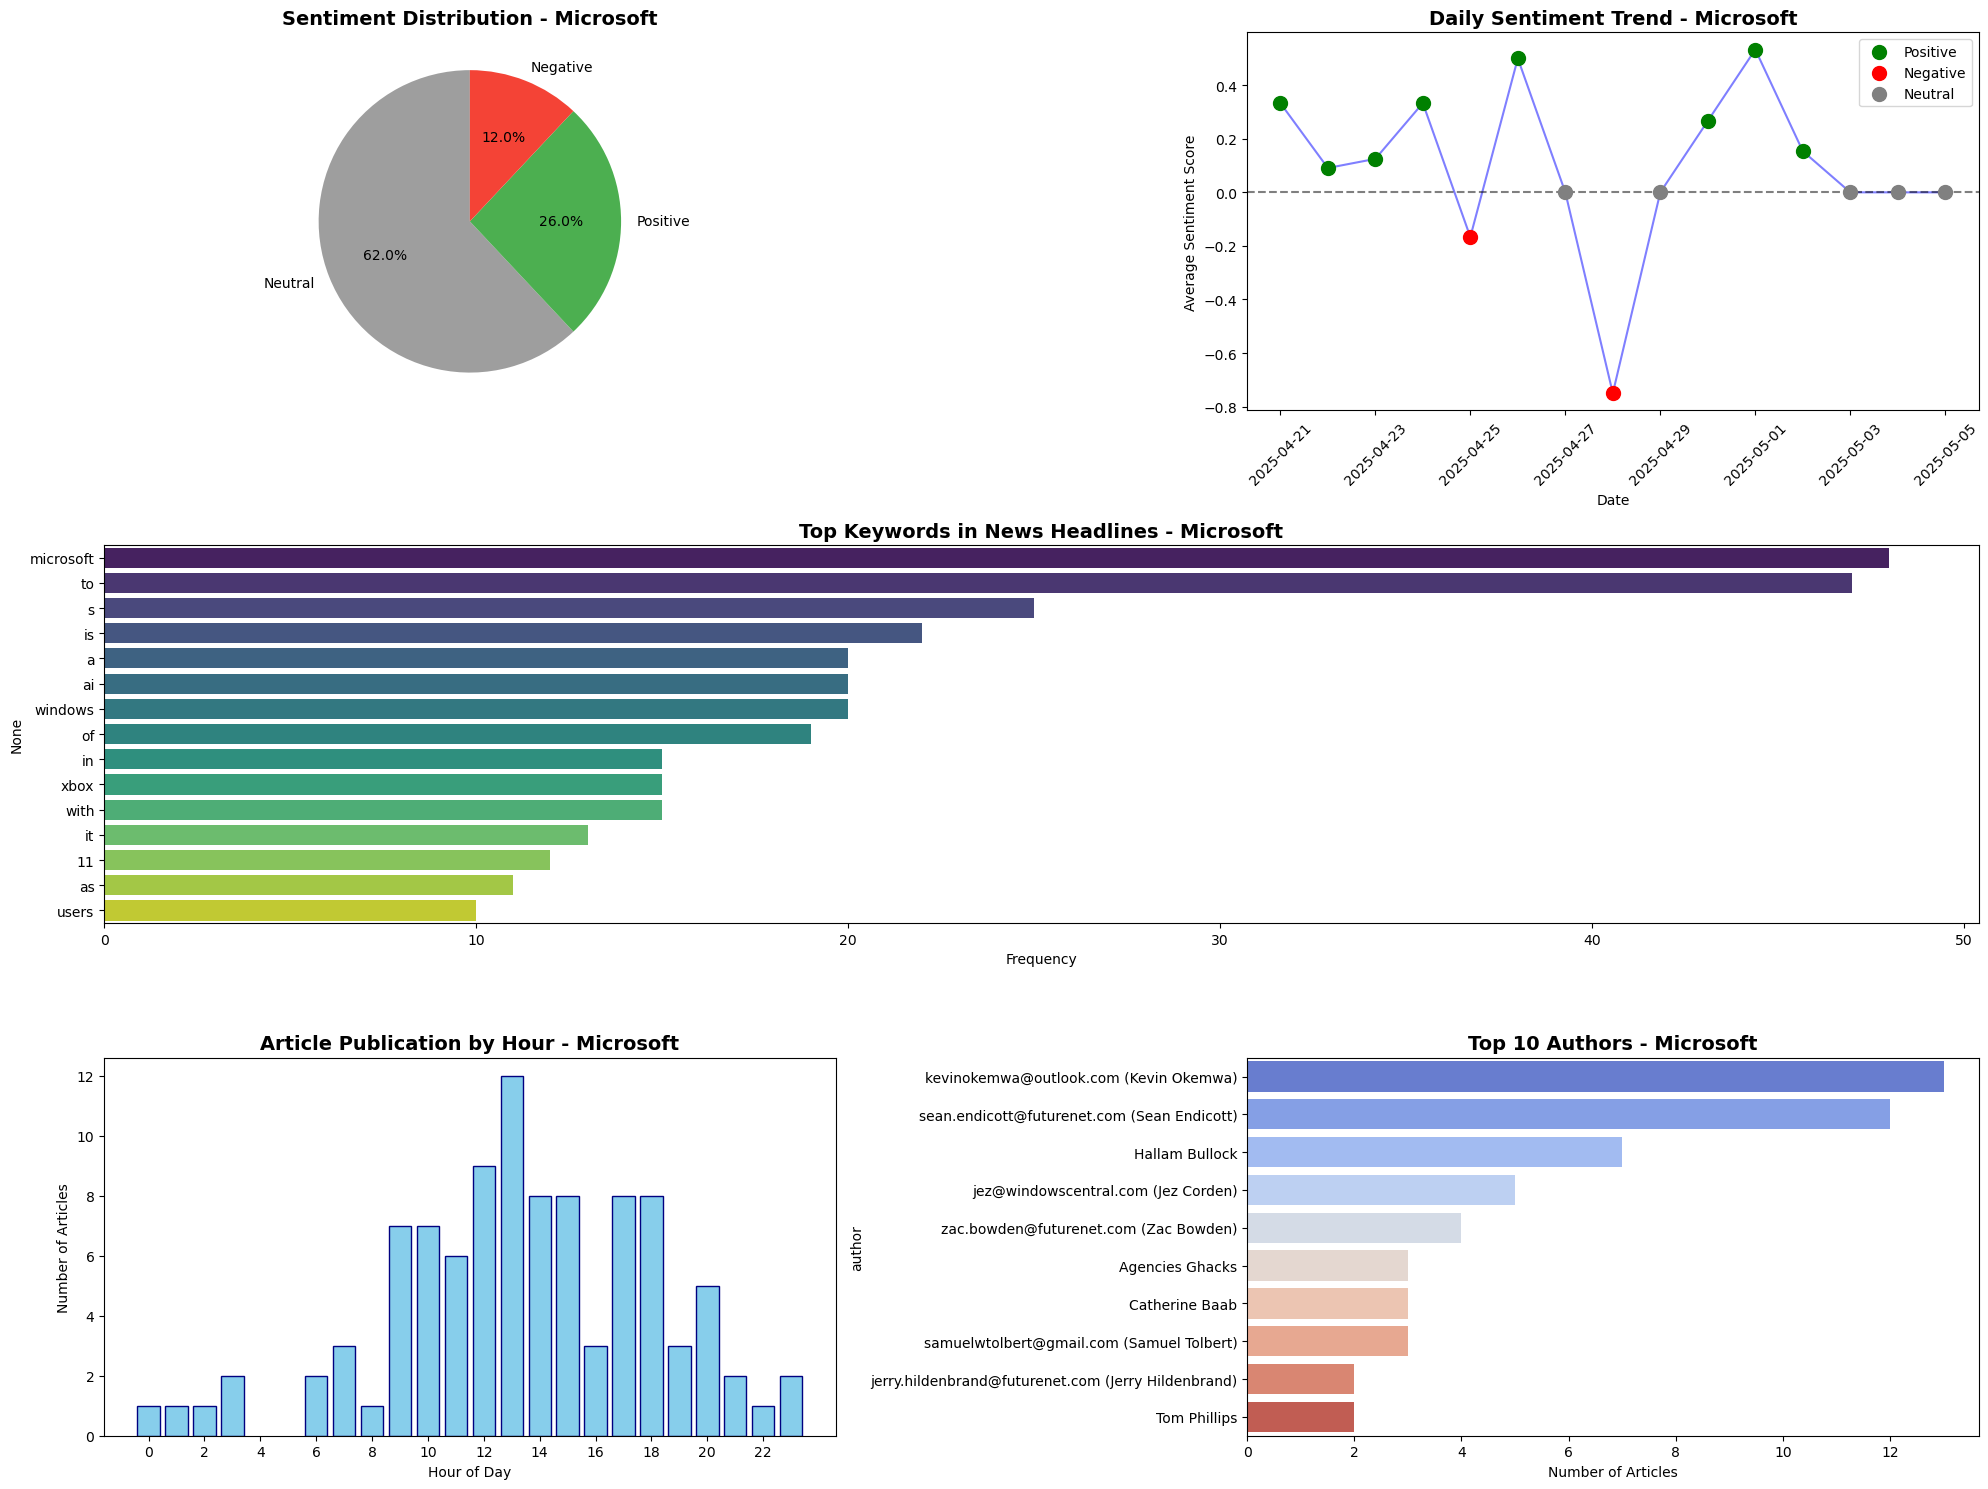

Generating analysis report for Microsoft...


2025-05-06 17:50:06,039 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analysis complete for Microsoft!

All analyses complete!
Individual reports and visualizations created for each company.


In [40]:
if __name__ == "__main__":
    main()

Fetching Microsoft stock data from 2025-04-21 to 2025-05-06

Data shape: (11, 7)
Available trading days: 11
Date range: 2025-04-21 to 2025-05-05

Microsoft Stock Data - Last 15 Trading Days:
                                 Open        High         Low       Close  \
Date                                                                        
2025-04-22 00:00:00-04:00  363.380005  367.769989  359.859985  366.820007   
2025-04-23 00:00:00-04:00  376.059998  380.390015  373.019989  374.390015   
2025-04-24 00:00:00-04:00  375.700012  388.450012  375.190002  387.299988   
2025-04-25 00:00:00-04:00  387.000000  392.160004  384.600006  391.850006   
2025-04-28 00:00:00-04:00  391.959991  392.739990  386.640015  391.160004   
2025-04-29 00:00:00-04:00  391.299988  395.100006  390.380005  394.040009   
2025-04-30 00:00:00-04:00  390.299988  396.660004  384.440002  395.260010   
2025-05-01 00:00:00-04:00  431.109985  436.989990  424.899994  425.399994   
2025-05-02 00:00:00-04:00  431.739990  

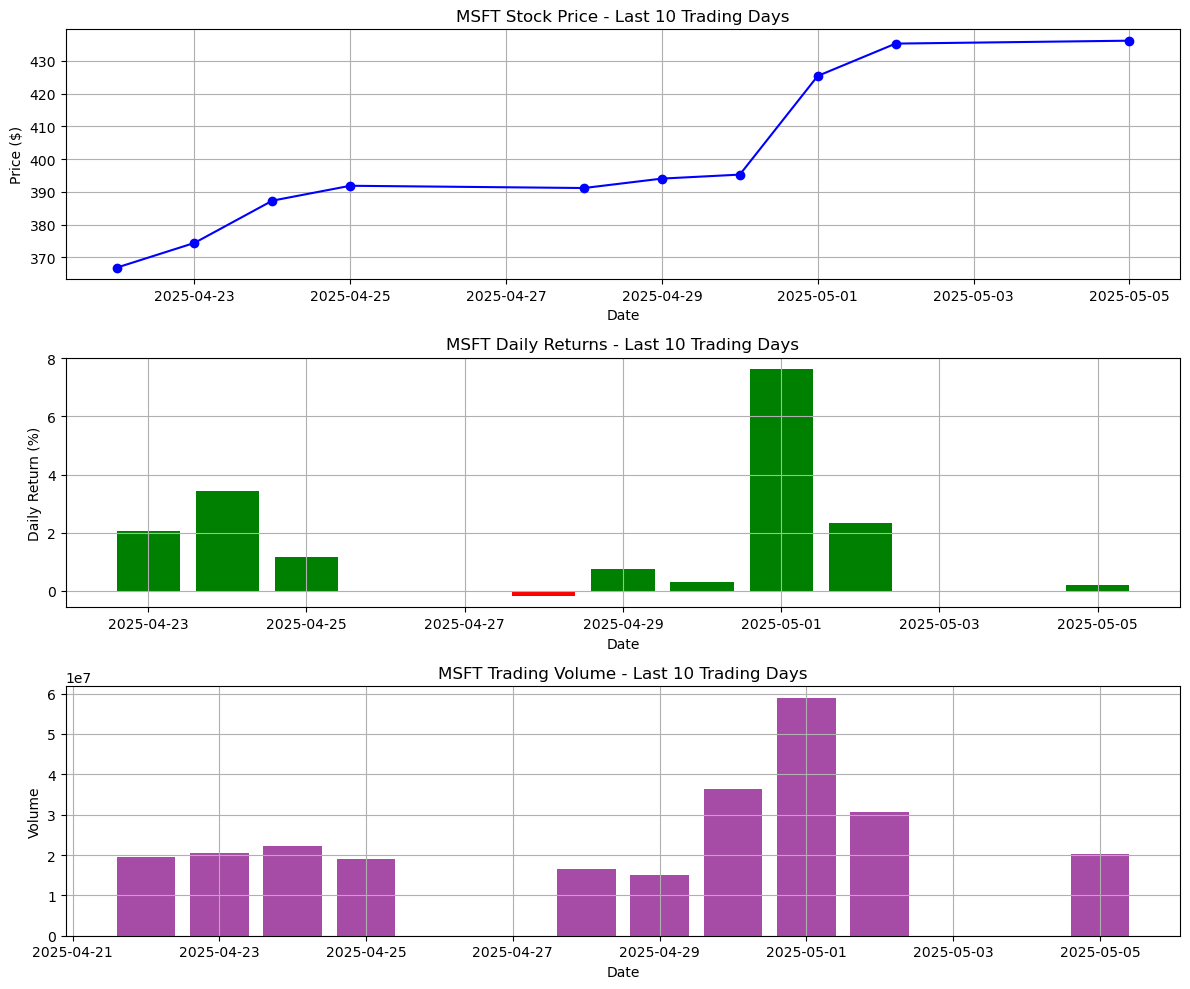

Error retrieving company info: Too Many Requests. Rate limited. Try after a while.


In [44]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def analyze_msft_stock():
    # Define the ticker
    ticker = "MSFT"
    
    # Calculate dates for last 10 days
    end_date = datetime.now()
    start_date = end_date - timedelta(days=15)  # Getting a few extra days to ensure we have 10 trading days
    
    # Format dates as strings
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')
    
    print(f"Fetching Microsoft stock data from {start_date_str} to {end_date_str}")
    
    try:
        # Download the data
        msft = yf.Ticker(ticker)
        hist = msft.history(start=start_date_str, end=end_date_str)
        
        if hist.empty:
            print("No data retrieved. Please check your internet connection or yfinance status.")
            return
            
        # Print info about the data
        print(f"\nData shape: {hist.shape}")
        print(f"Available trading days: {hist.shape[0]}")
        print(f"Date range: {hist.index[0].strftime('%Y-%m-%d')} to {hist.index[-1].strftime('%Y-%m-%d')}")
        
        # Get the most recent 10 trading days
        last_10_days = hist.tail(10)
        
        print("\nMicrosoft Stock Data - Last 15 Trading Days:")
        print(last_10_days[['Open', 'High', 'Low', 'Close', 'Volume']])
        
        # daily returns
        last_10_days['Daily Return'] = last_10_days['Close'].pct_change() * 100
        
        # Calculate statistics
        avg_close = last_10_days['Close'].mean()
        max_close = last_10_days['Close'].max()
        min_close = last_10_days['Close'].min()
        total_return = ((last_10_days['Close'].iloc[-1] / last_10_days['Close'].iloc[0]) - 1) * 100
        avg_volume = last_10_days['Volume'].mean()
        
        # Print summary statistics
        print("\nSummary Statistics:")
        print(f"Average Closing Price: ${avg_close:.2f}")
        print(f"Maximum Closing Price: ${max_close:.2f}")
        print(f"Minimum Closing Price: ${min_close:.2f}")
        print(f"Total Return over Period: {total_return:.2f}%")
        print(f"Average Daily Trading Volume: {avg_volume:.0f} shares")
        
        # Create plots
        plt.figure(figsize=(12, 10))
        
        #Price chart with daily closing prices
        plt.subplot(3, 1, 1)
        plt.plot(last_10_days.index, last_10_days['Close'], marker='o', linestyle='-', color='blue')
        plt.title(f'{ticker} Stock Price - Last 10 Trading Days')
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.grid(True)
        
        #Daily returns
        plt.subplot(3, 1, 2)
        colors = ['green' if x > 0 else 'red' for x in last_10_days['Daily Return']]
        plt.bar(last_10_days.index, last_10_days['Daily Return'], color=colors)
        plt.title(f'{ticker} Daily Returns - Last 10 Trading Days')
        plt.xlabel('Date')
        plt.ylabel('Daily Return (%)')
        plt.grid(True)
        
        #Volume
        plt.subplot(3, 1, 3)
        plt.bar(last_10_days.index, last_10_days['Volume'], color='purple', alpha=0.7)
        plt.title(f'{ticker} Trading Volume - Last 10 Trading Days')
        plt.xlabel('Date')
        plt.ylabel('Volume')
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(f"{ticker}_last_10_days_analysis.png")
        print(f"\nSaved chart as {ticker}_last_10_days_analysis.png")
        plt.show()
        
        #additional company info
        try:
            company_info = msft.info
            print("\nAdditional Company Information:")
            print(f"Company Name: {company_info.get('longName', 'N/A')}")
            print(f"Industry: {company_info.get('industry', 'N/A')}")
            print(f"Sector: {company_info.get('sector', 'N/A')}")
            print(f"Market Cap: ${company_info.get('marketCap', 0)/1e9:.2f} Billion")
            print(f"52 Week High: ${company_info.get('fiftyTwoWeekHigh', 'N/A')}")
            print(f"52 Week Low: ${company_info.get('fiftyTwoWeekLow', 'N/A')}")
            
            # Exporting data to CSV
            last_10_days.to_csv(f"{ticker}_last_10_days.csv")
            print(f"\nData exported to {ticker}_last_10_days.csv")
            
        except Exception as e:
            print(f"Error retrieving company info: {e}")
    
    except Exception as e:
        print(f"Error: {e}")
        print("\nIf you haven't installed the required packages, run:")
        print("pip install yfinance pandas matplotlib")

if __name__ == "__main__":
    analyze_msft_stock()

Above LLM analysed last 15 days news sentiment and above plots suggest the close price and returns of last ten days i.e 04/21/2025 to 05/05/2025